In [46]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [47]:
# Load the dataset
train_data = pd.read_csv('data/2_new_train.csv')
train_ros_adta = pd.read_csv('data/2_new_train_ros.csv')
train_smote_data = pd.read_csv('data/2_new_train_smote.csv')

# Extract X and y
X = train_data.drop(['credit_score'], axis=1)
X_ros = train_ros_adta.drop(['credit_score'], axis=1)
X_smote = train_smote_data.drop(['credit_score'], axis=1)
y = train_data['credit_score']
y_ros = train_ros_adta['credit_score']
y_smote = train_smote_data['credit_score']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71097 entries, 0 to 71096
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        71097 non-null  int64  
 1   age                          71097 non-null  float64
 2   annual_income                71097 non-null  float64
 3   monthly_inhand_salary        71097 non-null  float64
 4   num_bank_accounts            71097 non-null  float64
 5   num_credit_card              71097 non-null  float64
 6   interest_rate                71097 non-null  float64
 7   num_of_loan                  71097 non-null  float64
 8   delay_from_due_date          71097 non-null  float64
 9   num_of_delayed_payment       71097 non-null  float64
 10  changed_credit_limit         71097 non-null  float64
 11  num_credit_inquiries         71097 non-null  float64
 12  credit_mix                   71097 non-null  int64  
 13  outstanding_debt

In [48]:
def evaluate_model(model, X, y, model_name):
    """针对所有模型使用相同的手动交叉验证方法"""
    # 获取类别标签
    class_labels = sorted(np.unique(y))
    
    # 设置交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 基础指标
    accuracy_scores = []
    precision_macro_scores = []
    recall_macro_scores = []
    f1_macro_scores = []
    f1_weighted_scores = []  # 加权F1
    roc_auc_scores = []
    
    # 每个类别的指标
    per_class_precision = {cls: [] for cls in class_labels}
    per_class_recall = {cls: [] for cls in class_labels}
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 训练模型
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # 对于多类别问题获取概率
        y_proba = model.predict_proba(X_test)
        
        # 计算基础指标
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_macro_scores.append(precision_score(y_test, y_pred, average='macro'))
        recall_macro_scores.append(recall_score(y_test, y_pred, average='macro'))
        f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
        f1_weighted_scores.append(f1_score(y_test, y_pred, average='weighted'))
        
        # 多类别ROC AUC
        roc_auc_scores.append(roc_auc_score(y_test, y_proba, multi_class='ovr'))
        
        # 每个类别的精确率和召回率
        for cls in class_labels:
            y_test_binary = (y_test == cls)
            y_pred_binary = (y_pred == cls)
            per_class_precision[cls].append(precision_score(y_test_binary, y_pred_binary, zero_division=0))
            per_class_recall[cls].append(recall_score(y_test_binary, y_pred_binary, zero_division=0))
    
    # 整合结果
    results = {
        'Model': model_name,
        'Accuracy': np.mean(accuracy_scores),
        'Macro Precision': np.mean(precision_macro_scores),
        'Macro Recall': np.mean(recall_macro_scores),
        'Macro F1': np.mean(f1_macro_scores),
        'Weighted F1': np.mean(f1_weighted_scores),
        'ROC AUC': np.mean(roc_auc_scores)
    }
    
    # 添加每个类别的详细指标
    for cls in class_labels:
        results[f'Class {cls} Precision'] = np.mean(per_class_precision[cls])
        results[f'Class {cls} Recall'] = np.mean(per_class_recall[cls])
    
    return results

In [49]:
def visualize_results(results_list):
    """Visualize evaluation results for different models"""
    results_df = pd.DataFrame(results_list).set_index('Model')
    
    # 1. Main metrics bar chart
    main_metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1', 'Weighted F1', 'ROC AUC']
    plt.figure(figsize=(14, 7))
    results_df[main_metrics].plot(kind='bar')
    plt.title('Model Performance Comparison - Main Metrics')
    plt.ylabel('Score')
    # plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(main_metrics), frameon=True)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 2. Class-specific precision and recall
    class_metrics = [col for col in results_df.columns if 'Class' in col]
    if class_metrics:
        plt.figure(figsize=(14, 7))
        sns.heatmap(results_df[class_metrics], annot=True, cmap='YlGnBu', fmt='.3f')
        plt.title('Precision and Recall by Class')
        plt.tight_layout()
        plt.show()
    
    # 3. Comprehensive score
    results_df['Comprehensive Score'] = 0.5 * results_df['Macro F1'] + 0.5 * results_df['Accuracy']
    plt.figure(figsize=(10, 5))
    results_df['Comprehensive Score'].sort_values().plot(kind='barh', figsize=(10, 5))
    plt.title('Model Performance - Comprehensive Score')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return results_df

# 初始化模型
models = [
    (LogisticRegression(max_iter=10000, random_state=42), 'Logistic Regression'),
    (RandomForestClassifier(random_state=42), 'Random Forest'),
    (xgb.XGBClassifier(random_state=42), 'XGBoost')
]

In [ ]:
results = []
results_ros = []
results_smote = []
for model, name in models:
    print(f"Training {name}...")
    result = evaluate_model(model, X, y, name)
    result_ros = evaluate_model(model, X_ros, y_ros, name)
    result_smote = evaluate_model(model, X_smote, y_smote, name)
    results.append(result)
    results_ros.append(result_ros)
    results_smote.append(result_smote)

Training Logistic Regression...


<Figure size 800x300 with 0 Axes>

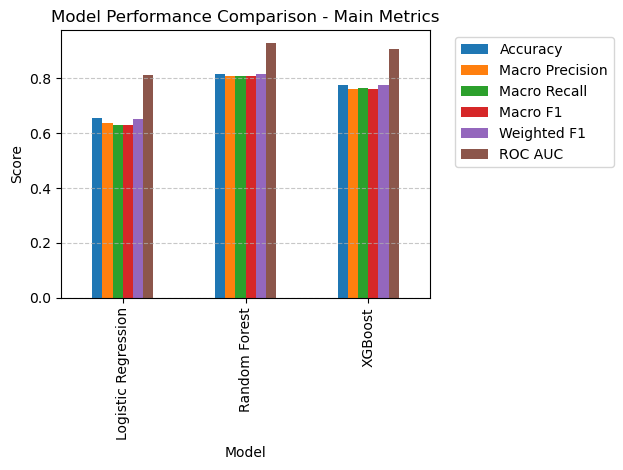

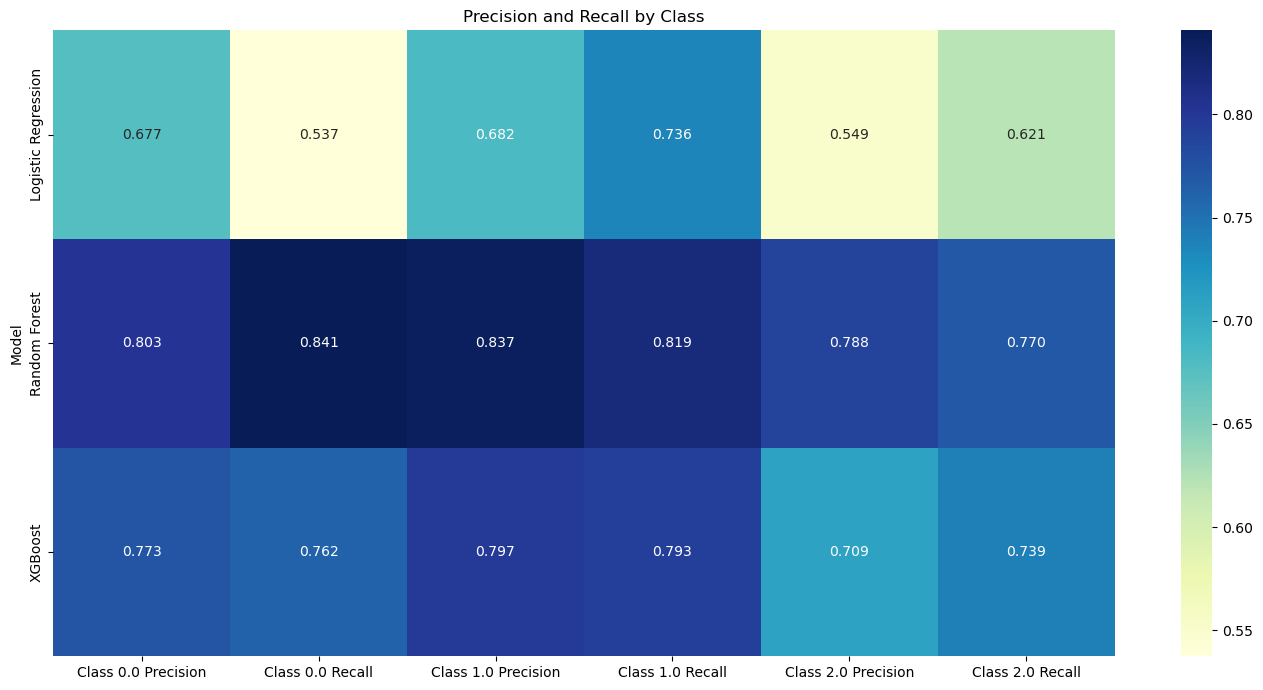

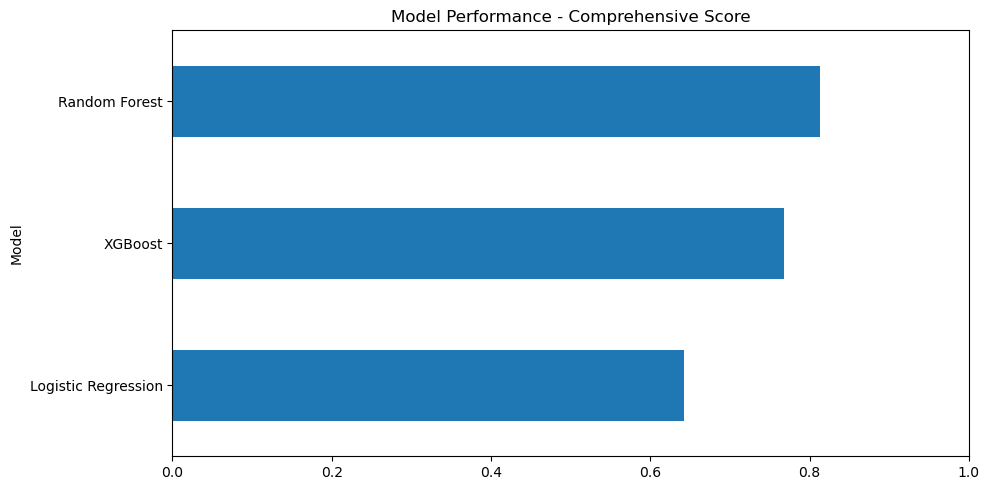


详细评估指标:


,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1,ROC AUC,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model,,,,,,,,,,,,,
Logistic Regression,0.655710,0.636092,0.631345,0.629958,0.653604,0.811984,0.676917,0.537334,0.681980,0.736027,0.549380,0.620675,0.642834
Random Forest,0.817686,0.809091,0.809986,0.809307,0.817632,0.929106,0.802576,0.840773,0.836512,0.819425,0.788183,0.769762,0.813497
XGBoost,0.774590,0.759849,0.764809,0.762200,0.774777,0.907979,0.773023,0.762487,0.797270,0.792990,0.709255,0.738951,0.768395


In [ ]:
# 可视化比较结果
results_df = visualize_results(results)

# 打印详细指标表格
print("\n详细评估指标:")
display(results_df)

<Figure size 800x300 with 0 Axes>

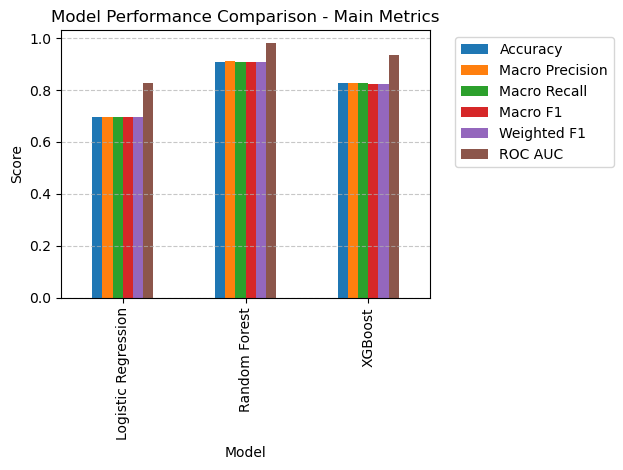

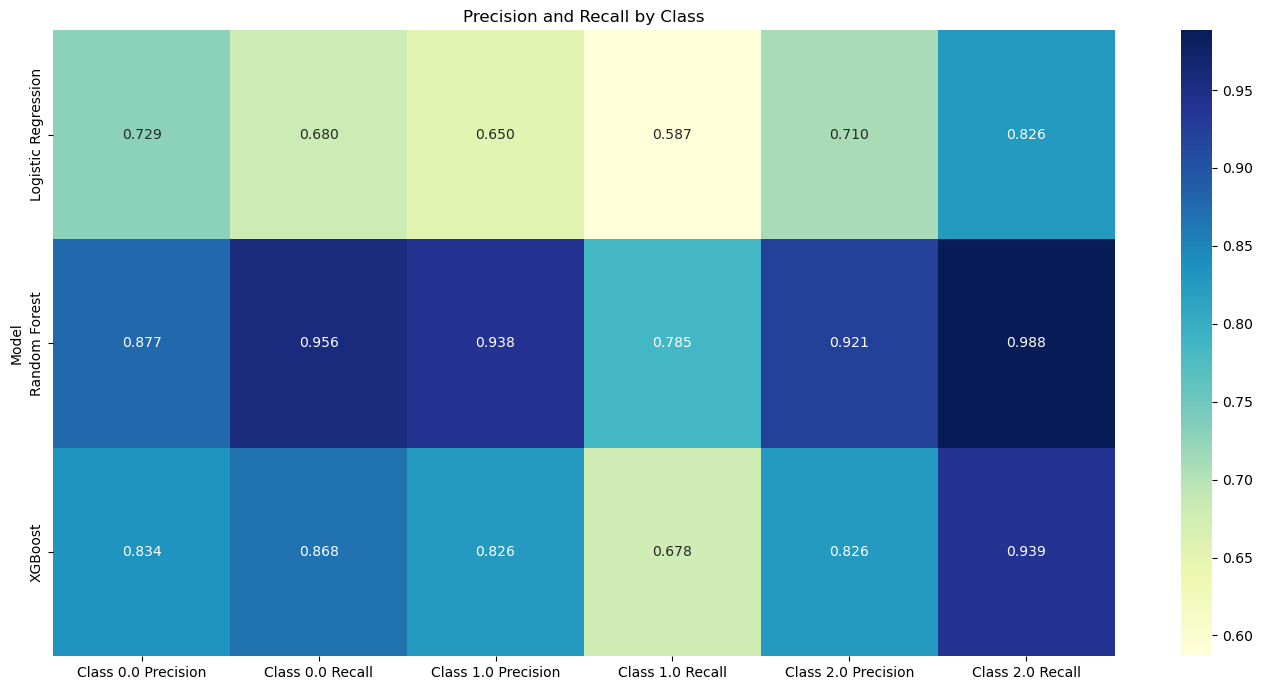

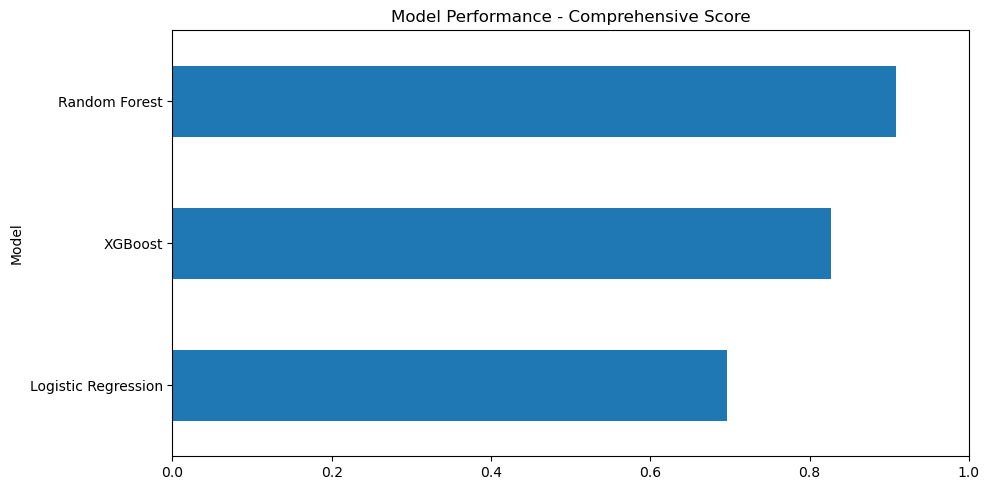


详细评估指标:


,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1,ROC AUC,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model,,,,,,,,,,,,,
Logistic Regression,0.697650,0.696141,0.697650,0.694592,0.694592,0.825455,0.728752,0.680027,0.649973,0.586622,0.709697,0.826301,0.696121
Random Forest,0.909984,0.912239,0.909984,0.907889,0.907889,0.981202,0.876949,0.956254,0.938273,0.785365,0.921496,0.988334,0.908937
XGBoost,0.828557,0.828499,0.828557,0.824769,0.824769,0.936151,0.833743,0.868094,0.826192,0.678475,0.825561,0.939104,0.826663


In [ ]:
# 可视化比较结果
results_ros_df = visualize_results(results_ros)

# 打印详细指标表格
print("\n详细评估指标:")
display(results_ros_df)

<Figure size 800x300 with 0 Axes>

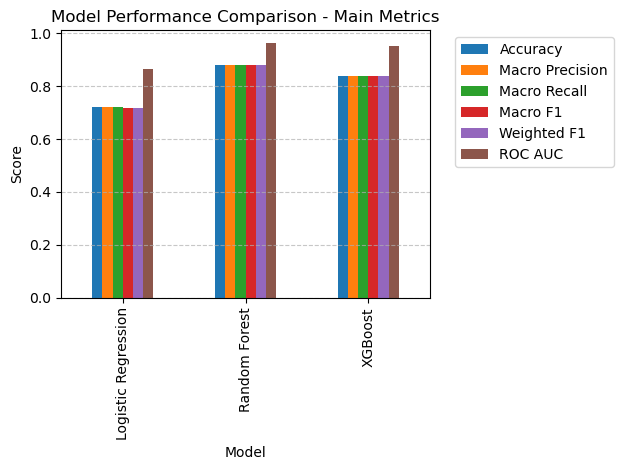

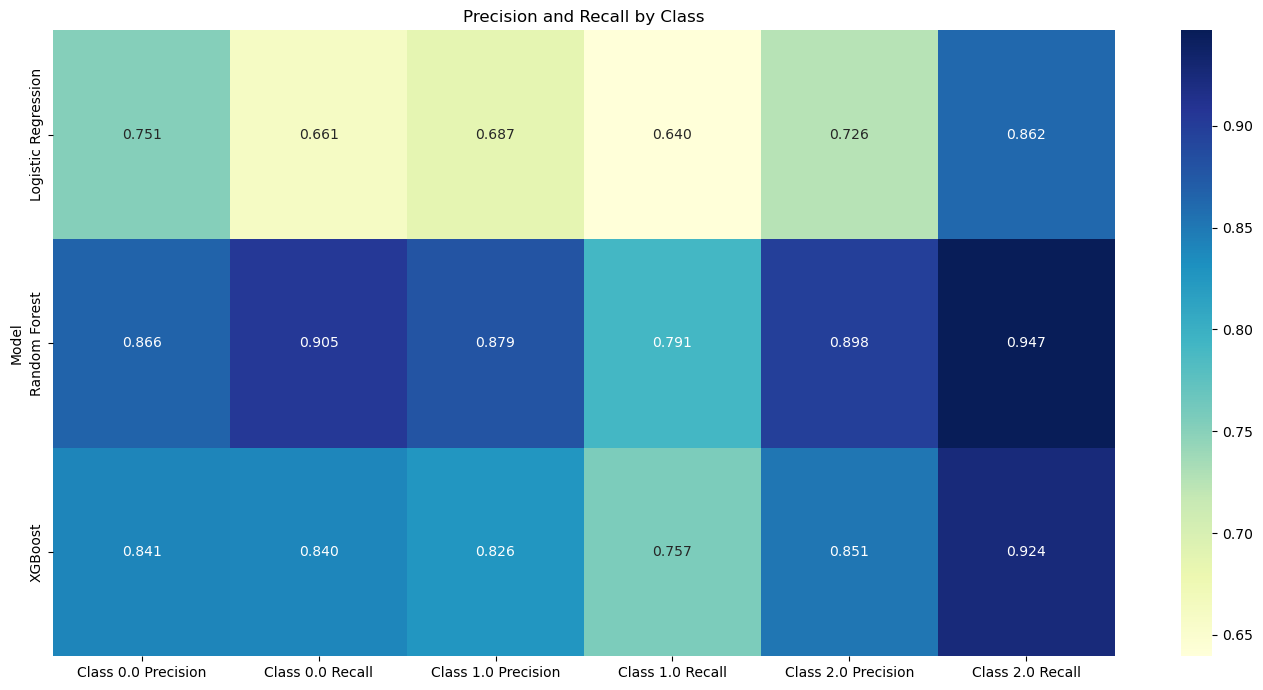

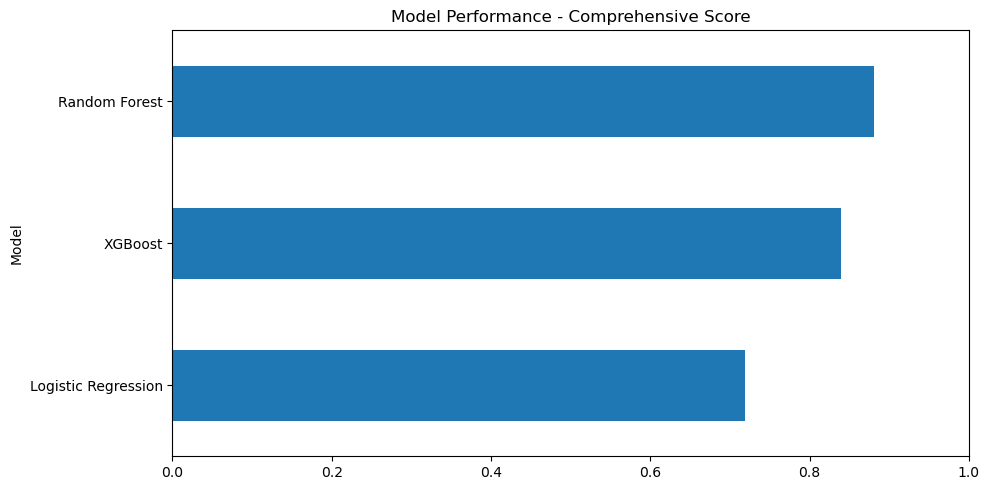


详细评估指标:


,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1,ROC AUC,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model,,,,,,,,,,,,,
Logistic Regression,0.721026,0.721169,0.721026,0.717880,0.717880,0.865745,0.751198,0.661057,0.686592,0.639545,0.725718,0.862475,0.719453
Random Forest,0.880954,0.880810,0.880954,0.879760,0.879760,0.963586,0.865514,0.904508,0.878757,0.791492,0.898160,0.946863,0.880357
XGBoost,0.840268,0.839564,0.840268,0.838901,0.838901,0.951618,0.841105,0.839652,0.826113,0.756763,0.851472,0.924388,0.839584


In [ ]:
# 可视化比较结果
results_smote_df = visualize_results(results_smote)

# 打印详细指标表格
print("\n详细评估指标:")
display(results_smote_df)

In [ ]:
# # 可视化模型性能比较
# plt.figure(figsize=(12, 6))
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# x = np.arange(len(models))
# width = 0.2

# for i, metric in enumerate(metrics):
#     plt.bar(x + i*width, results_df[metric], width, label=metric)

# plt.xlabel('Models')
# plt.ylabel('Score')
# plt.title('Model Performance Comparison')
# plt.xticks(x + width*1.5, results_df.index)
# plt.legend()
# plt.tight_layout()
# plt.savefig('./image/model_performance_comparison.png')
# plt.show()